In [25]:
import tensorflow as tf
from scipy import stats
import numpy as np

from matplotlib import pyplot as plt
from matplotlib.patches import Patch
from matplotlib import rc
import matplotlib.font_manager
rc('font', family='serif')
rc('text', usetex=True)
rc('font', size=10)        #22
rc('xtick', labelsize=8)  #15
rc('ytick', labelsize=8)  #15
rc('legend', fontsize=8)  #15
rc('text.latex', preamble=r'\usepackage{amsmath}')

# Plots have dimension (w,h)
w = 3.5
h = 3.25       

from flows import *

import os

In [6]:
os.environ["CUDA_VISIBLE_DEVICES"] = "3" # pick a number < 4 on ML4HEP; < 3 on Voltan 
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [7]:
mc = np.load("../data/zenodo/Pythia21_Zjet_pTZ-200GeV_0.npz")

sim_pt =  mc['sim_jets'][:, 0]
sim_eta = mc['sim_jets'][:, 1]
sim_phi = mc['sim_jets'][:, 2]
sim_m =   mc['sim_jets'][:, 3]

sim = np.vstack([sim_pt, sim_eta, sim_phi, sim_m]).T

In [8]:
dat = np.load("../data/zenodo/Herwig_Zjet_pTZ-200GeV_0.npz")

dat_pt =  dat['sim_jets'][:, 0] # dat[:, 0]
dat_eta = dat['sim_jets'][:, 1]
dat_phi = dat['sim_jets'][:, 2]
dat_m =   dat['sim_jets'][:, 3]

dat = np.vstack([dat_pt, dat_eta, dat_phi, dat_m]).T

In [9]:
n, d = dat.shape

In [10]:
dat_target = make_target(d)
sim_target = make_target(d)

dat_ckpt = tf.train.Checkpoint(dat_target)
sim_ckpt = tf.train.Checkpoint(sim_target)

2023-02-03 21:37:42.772599: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-03 21:37:43.343305: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22824 MB memory:  -> device: 0, name: Quadro RTX 6000, pci bus id: 0000:c1:00.0, compute capability: 7.5


In [11]:
dat_ckpt.restore('dat/ckpt-79')
sim_ckpt.restore('sim/ckpt-79')

In [83]:
def ratio_hist(truth, fit,
               labels,
               figsize = (8, 8),
               x_lim = None,
               y_lim = None,
               title = None,
               filename = None):
    fig, axs = plt.subplots(2, 1,
                            figsize = figsize,
                            sharex = True, 
                            gridspec_kw = {'height_ratios': [2, 1]})
    t_hist = axs[0].hist(truth, bins = 50, density = True, color = 'gray', alpha = 0.5, label = labels[0])
    f_hist = axs[0].hist(fit, bins = 50, density = True, histtype = 'step', color = 'red', label = labels[1])
    
    if y_lim:
        axs[0].set_ylim(y_lim[0], y_lim[1])
    if x_lim:
        axs[0].set_xlim(x_lim[0], x_lim[1])
    
    bins = (f_hist[1] + np.diff(f_hist[1]).mean() / 2)[:-1]
    axs[1].scatter(bins, f_hist[0] / t_hist[0], marker = '_', c = 'red')
    axs[1].axhline(1,ls=":",color="gray", lw=0.5)
    plt.xlabel(labels[2])
    
    if title:
        axs[0].set_title(title, loc = "right")
    if filename:
        plt.savefig(filename, 
                    dpi = 300,
                    transparent = True,
                    bbox_inches = 'tight')

In [12]:
dat_smp = dat_target.sample(n)
sim_smp = sim_target.sample(n)

In [ ]:
fig, axs = plt.subplots(2, 1,
                        figsize = figsize,
                        sharex = True, 
                        gridspec_kw = {'height_ratios': [2, 1]})

In [ ]:
ratio_hist(dat[:, 0], dat_smp[:, 0], 
           labels = ['Data', 'Flow', r'$p_T$'],
           figsize = (w, h),
           title = r'\it $p_T$ (Data)',
           x_lim = (0, 750),
           filename = 'pT_data.png'
          )

In [ ]:
ratio_hist(dat[:, 1], dat_smp[:, 1], 
           labels = ['Data', 'Flow', r'$\eta$'],
           figsize = (w, h),
           title = r'\it $\eta$ (Data)',
           x_lim = (-5, 5),
           filename = 'eta_data.png'
          )

(0.0, 1000.0)

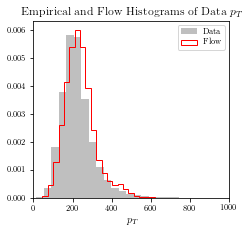

In [62]:
fig, ax = plt.subplots(figsize = (w, h))
dhist = plt.hist(dat[:, 0], bins = 50, density = True, color = 'gray', alpha = 0.5, label = 'Data')
fhist = plt.hist(dat_smp[:, 0], bins = 50, density = True, histtype = 'step', color = 'red', label = 'Flow')

plt.title(r'Empirical and Flow Histograms of Data $p_T$')
plt.xlabel(r'$p_T$')
plt.legend()

plt.xlim(0, 1000)

In [63]:
fhist[0] / dhist[0]

/tmp/ipykernel_27798/1696297040.py:1: RuntimeWarning: divide by zero encountered in divide
  fhist[0] / dhist[0]


array([ 0.20095272,  0.21407993,  0.24896051,  0.33999864,  0.44488144,
        0.7176667 ,  1.52124565,  3.01403489,  4.93907048,  6.04184243,
        6.67733397,  5.63270913,  6.03044676,  5.94820004,  7.13680999,
       11.32162251,  9.65843826,  7.33553931,  3.63799133,  5.34503356,
        4.01905408,  1.63757731,  2.88905916,  5.41698593,  4.05401137,
        5.31214104,  5.59172741, 18.17311409,  2.19675005,  6.0577047 ,
        5.24224445, 25.16277336, 32.15243262,         inf,         inf,
        1.39793185,  0.        ,         inf,         inf,         inf,
               inf, 27.95869912,         inf,         inf,         inf,
               inf,         inf,         inf,         inf,  1.39793496])

In [64]:
fhist[1]

array([  18.46295 ,   45.962887,   73.46282 ,  100.96275 ,  128.46269 ,
        155.96263 ,  183.46255 ,  210.9625  ,  238.46243 ,  265.96237 ,
        293.4623  ,  320.96225 ,  348.4622  ,  375.9621  ,  403.46204 ,
        430.96198 ,  458.4619  ,  485.96185 ,  513.4618  ,  540.96173 ,
        568.4617  ,  595.9616  ,  623.46155 ,  650.9615  ,  678.4614  ,
        705.9613  ,  733.46124 ,  760.9612  ,  788.4611  ,  815.96106 ,
        843.461   ,  870.96094 ,  898.4609  ,  925.9608  ,  953.46075 ,
        980.9607  , 1008.46063 , 1035.9606  , 1063.4604  , 1090.9604  ,
       1118.4603  , 1145.9603  , 1173.4602  , 1200.9602  , 1228.4601  ,
       1255.9601  , 1283.46    , 1310.96    , 1338.4598  , 1365.9598  ,
       1393.4597  ], dtype=float32)

In [65]:
ff = (fhist[1] + np.diff(fhist[1]).mean() / 2)[:-1]
dd = (dhist[1] + np.diff(dhist[1]).mean() / 2)[:-1]

/tmp/ipykernel_27798/289737468.py:1: RuntimeWarning: divide by zero encountered in divide
  plt.scatter(ff, fhist[0] / dhist[0], marker = '_')


(0.0, 2.0)

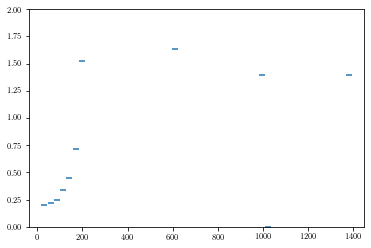

In [66]:
plt.scatter(ff, fhist[0] / dhist[0], marker = '_')
plt.ylim(0, 2)